# Analysing the impact of the One Drug Database on OpenPrescribing

February 2020

The BSA publish the [Detailed Prescribing Information](https://www.nhsbsa.nhs.uk/prescription-data/prescribing-data/detailed-prescribing-information) dataset monthly, which contains the number of items prescribed of each presentation for each practice.  In 2020 they are changing the underlying database which produces this dataset.  This is called the [One Drug Database project](https://www.nhsbsa.nhs.uk/important-information-drug-data), and these changes will affect the Detailed Prescribing Information dataset that we use.

We expect to be affected by two changes.

## Change 1: BNF code changes

There will be a rationalisation of BNF codes.  In particular:

> BNF codes will change for products (drugs and appliances) where the pack size is currently shown as part of the naming convention.

[1501 presentations](#Distribution-of-numbers-of-new-presentations-that-are-mapped-to) are affected by changed BNF codes.

However, it looks like there has been a much larger rationalisation of BNF codes.

Changes include:

* [Old "Liq Spec" presentation disaggregated into "oral solution" and "oral suspension" presentations](#Old-"Liq-Spec"-presentation-disaggregated-into-"oral-solution"-and-"oral-suspension"-presentations)
* [Old brandend presentation disaggregated into branded and generic presentations](#Old-brandend-presentation-disaggregated-into-branded-and-generic-presentations)
* [Old presentation disaggregated into more accurately named presentations](#Old-presentation-disaggregated-into-more-accurately-named-presentations)
* [Branded appliances into branded presentation and generic presentation in chapter 13](#Branded-appliances-into-branded-presentation-and-generic-presentation-in-chapter-13)
* [An old version of a presentation is combined with the current version of the same](#An-old-version-of-a-presentation-is-combined-with-the-current-version-of-the-same)
* [An "Oral Soln" presentation is combined with an "Oral Susp" presentation](#An-"Oral-Soln"-presentation-is-combined-with-an-"Oral-Susp"-presentation)
* [Presentations of different flavour are combined](#Presentations-of-different-flavour-are-combined)
* [Presentations of different dose size are combined](#Presentations-of-different-dose-size-are-combined)
* [Branded presentations are combined into a generic presentation](#Branded-presentations-are-combined-into-a-generic-presentation)

Presentations affected by changed BNF codes account for [1.3% of items and 1.4% of net_cost in November 2019](#Percentage-of-items-and-net_cost-that-are-affected-by-change-1).

1% of presentations account for [55% of items](#Distribution-of-presentations-affected-by-change-1,-by-items) and [29% of net_cost](#Distribution-of-presentations-affected-by-change-1,-by-net_cost), and 10% of presentations account for [89% of items](#Distribution-of-presentations-affected-by-change-1,-by-items) and [82% of net_cost](#Distribution-of-presentations-affected-by-change-1,-by-net_cost).

The 10 presentations most affected by changes in items are shown [here](#Top-10-presentations-affected-by-change-1,-by-items), and the 10 presentations most affected by changes in net_cost are shown [here](#Top-10-presentations-affected-by-change-1,-by-net_cost).

## Change 2: special container quantity changes

Some special container packs currently include the pack size in the drug name, and the quantity field represents the number of packs.  Once the ODD changes are applied:

> the quantity will be represented as the total quantity (for example, the number of mls or gms), instead of the number of special container packs.

Presentations affected by changed BNF codes account for [1.5% of items and 3.2% of net_cost in November 2019](#Percentage-of-items-and-net_cost-that-are-affected-by-change-2).

1% of presentations account for [44% of items](#Distribution-of-presentations-affected-by-change-2,-by-items) and [31% of net_cost](#Distribution-of-presentations-affected-by-change-2,-by-net_cost), and 10% of presentations account for [87% of items](#Distribution-of-presentations-affected-by-change-2,-by-items) and [84% of net_cost](#Distribution-of-presentations-affected-by-change-2,-by-net_cost).

The 10 presentations most affected by changes in items are shown [here](#Top-10-presentations-affected-by-change-2,-by-items), and the 10 presentations most affected by changes in net_cost are shown [here](#Top-10-presentations-affected-by-change-2,-by-net_cost).

---

## Housekeeping

In [1]:
# Imports from the standard library
import json
from collections import Counter

# Imports from third-party packages
import pandas as pd
from ebmdatalab import bq

In [2]:
# Ensure that DataFrames columns are not truncated
pd.set_option('display.max_colwidth', -1)

### Total items and net_cost for November 2019

In [3]:
# Query the prescribing data in BigQuery for the total items and net_cost 
sql = """
SELECT
    SUM(items) AS items,
    SUM(net_cost_pence) / 100 AS net_cost
FROM public_draft.prescribing
WHERE month = '2019-11-01'
"""

df = bq.cached_read(sql, csv_path='../bq-cache/2019_11_items_and_spending.csv')
df

,items,net_cost
0,93549790,7.585725e+08


In [4]:
# Save these off for later -- we'll want to see what proprtion the items and net_cost are affected by the changes
total_items, total_net_cost = df.iloc[0]

---

## Change 1: BNF code changes

### Affected presentations

In [5]:
# Load the data from the spreadsheet
bnf_mapping_raw = pd.read_excel('../data/MDR BNF to dm+d BNF Mapping.xlsx')
bnf_mapping_raw.head()

,Current BNF Code,MDR: BNF Description,New BNF Code,dm+d: BNF Description,BNF Code Changed (Y/N)
0,0101010C0AAAAAA,Alum Hydrox_Cap 475mg,0101010C0AAAAAA,Aluminium hydroxide 475mg capsules,N
1,0101010C0AAACAC,Alum Hydrox_Oral Susp S/F,0101010C0AAACAC,Aluminium hydroxide oral suspension sugar free,N
2,0101010C0AAAMAM,Alum Hydrox_Oral Susp 475mg/5ml,0101010C0AAAMAM,Aluminium hydroxide 475mg/5ml oral suspension,N
3,0101010C0BBAAAA,Alu-Cap_Cap 475mg,0101010C0BBAAAA,Alu-Cap 475mg capsules,N
4,0101010E0AAAEAE,Hydrotalcite_Oral Susp 500mg/5ml S/F,0101010E0AAAEAE,Hydrotalcite 500mg/5ml oral suspension sugar free,N


In [6]:
# Massage the data a bit, changing column names...
bnf_mapping = bnf_mapping_raw.rename(columns={
    'Current BNF Code': 'old_code',
    'MDR: BNF Description': 'old_name',
    'dm+d: BNF Description': 'new_name',
    'New BNF Code': 'new_code',
    'BNF Code Changed (Y/N)': 'changed'
})
# ...dropping rows where the code hasn't changed...
bnf_mapping = bnf_mapping[bnf_mapping['changed'] == 'Y']
# ...dropping rows where the old_code is in chapter 19...
bnf_mapping = bnf_mapping[~bnf_mapping['old_code'].str.startswith('19')]
# ...dropping rows where the new_code is in chapter 19...
bnf_mapping = bnf_mapping[~bnf_mapping['new_code'].str.startswith('19')]
# ...and sorting by old_code and new_code
bnf_mapping = bnf_mapping.sort_values(['old_code', 'new_code'])

print(f"There are {len(bnf_mapping)} changed records")
display(bnf_mapping.head())

There are 1946 changed records


,old_code,old_name,new_code,new_name,changed
56,0101010N0AAAAAA,Antacid/Oxetacaine_Oral Susp S/F,0101010N0AAABAB,Antacid and Oxetacaine oral suspension,Y
81,0101012B0AAAUAU,Sod Bicarb_Liq Spec 420mg/5ml,0101012B0AAABAB,Sodium bicarbonate 420mg/5ml (1mol/ml) soln sugar free,Y
97,0101012B0AABVBV,Sod Bicarb_Oral Soln 50mg/5ml (Old),0101012B0AABXBX,Sodium bicarbonate 50mg/5ml oral solution,Y
87,0101012B0AABWBW,Sod Bicarb_Oral Soln 420mg/5ml,0101012B0AAAUAU,Sodium bicarbonate 420mg/5ml (1mmol/ml) oral liquid,Y
100,0101012B0BKAABY,Boots_Gripe Mix S/F,0101012B0AABYBY,Sodium bicarbonate 50mg/5ml oral solution sugar free,Y


### Distribution of numbers of new presentations that are mapped to

_(Is there a better way to express this?)_

There are 1501 distinct old BNF codes:

In [7]:
bnf_mapping['old_code'].nunique()

1501

There are 1418 old BNF codes map to a single new BNF code, 37 old BNF codes map to 2 new BNF codes... and 1 maps to 112 new BNF codes:

In [8]:
old_code_counts = Counter(bnf_mapping['old_code'])
old_code_count_distribution = sorted(Counter(old_code_counts.values()).items())
rows = [
    [num_old_codes, num_new_codes_mapped_to]
    for num_new_codes_mapped_to, num_old_codes in old_code_count_distribution
]
pd.DataFrame(rows, columns=['num_old_codes', 'num_new_codes_mapped_to'])

,num_old_codes,num_new_codes_mapped_to
0,1418,1
1,37,2
2,41,3
3,1,5
4,2,57
5,1,100
6,1,112


### Old presentations mapping to 2 new codes

In [9]:
old_codes_mapping_to_2_new_codes = [code for code, count in old_code_counts.items() if count == 2]

with pd.option_context('display.max_rows', None):
    display(bnf_mapping[bnf_mapping["old_code"].isin(old_codes_mapping_to_2_new_codes)])

,old_code,old_name,new_code,new_name,changed
269,0102000L0AAAJAJ,Glycopyrronium Brom_Liq Spec 500mcg/5ml,0102000L0AABHBH,Glycopyrronium bromide 500micrograms/5ml oral solution,Y
271,0102000L0AAAJAJ,Glycopyrronium Brom_Liq Spec 500mcg/5ml,0102000L0AABIBI,Glycopyrronium bromide 500micrograms/5ml oral suspension,Y
1504,0204000H0AAAUAU,Bisoprolol Fumar_OralSoln1.25mg/5ml(Old),0204000H0AABIBI,Bisoprolol 1.25mg/5ml oral suspension,Y
1506,0204000H0AAAUAU,Bisoprolol Fumar_OralSoln1.25mg/5ml(Old),0204000H0AABJBJ,Bisoprolol 1.25mg/5ml oral solution,Y
1913,0205051L0AAAFAF,Lisinopril_Liq Spec 20mg/5ml,0205051L0AAAYAY,Lisinopril 20mg/5ml oral solution,Y
1915,0205051L0AAAFAF,Lisinopril_Liq Spec 20mg/5ml,0205051L0AAAZAZ,Lisinopril 20mg/5ml oral suspension,Y
2184,0206010F0AAAAAA,Glyceryl Trinit_Subling Spy 400mcg(200D),0206010F0AACGCG,Glyceryl trinitrate 400micrograms/dose aerosol SL spy,Y
2188,0206010F0AAAAAA,Glyceryl Trinit_Subling Spy 400mcg(200D),0206010F0AACICI,Glyceryl trinitrate 400micrograms/dose pump sublingual spray,Y
4108,0401010ADAABUBU,Melatonin_Liq Spec 10mg/5ml,0401010ADAACDCD,Melatonin 10mg/5ml oral solution,Y
4110,0401010ADAABUBU,Melatonin_Liq Spec 10mg/5ml,0401010ADAACECE,Melatonin 10mg/5ml oral suspension,Y


There are several patterns here that we can pick out:

#### Old "Liq Spec" presentation disaggregated into "oral solution" and "oral suspension" presentations

In [10]:
bnf_mapping[bnf_mapping["old_code"] == "0102000L0AAAJAJ"]

,old_code,old_name,new_code,new_name,changed
269,0102000L0AAAJAJ,Glycopyrronium Brom_Liq Spec 500mcg/5ml,0102000L0AABHBH,Glycopyrronium bromide 500micrograms/5ml oral solution,Y
271,0102000L0AAAJAJ,Glycopyrronium Brom_Liq Spec 500mcg/5ml,0102000L0AABIBI,Glycopyrronium bromide 500micrograms/5ml oral suspension,Y


#### Old brandend presentation disaggregated into branded and generic presentations

In [11]:
bnf_mapping[bnf_mapping["old_code"] == "070405000BBADA0"]

,old_code,old_name,new_code,new_name,changed
10719,070405000BBADA0,Invicorp-2_Inj Soln 1ml Amp,0704050ADAAAAAA,Phentolamine 2mg/0.35ml / Aviptadil 25microg/0.35ml inj amp,Y
10722,070405000BBADA0,Invicorp-2_Inj Soln 1ml Amp,0704050ADBBABAA,Invicorp 2 solution for injection,Y


#### Old presentation disaggregated into more accurately named presentations

In [12]:
bnf_mapping[bnf_mapping["old_code"] == "0906027G0AAABAB"]

,old_code,old_name,new_code,new_name,changed
14860,0906027G0AAABAB,Vit B Co Strong_Tab,090607000AABBBB,Multivitamin tablets,Y
15497,0906027G0AAABAB,Vit B Co Strong_Tab,091200000AAFTFT,Multinutrient tablets,Y


#### Branded appliances into branded presentation and generic presentation in chapter 13

In [13]:
bnf_mapping[bnf_mapping["old_code"] == "21220000234"]

,old_code,old_name,new_code,new_name,changed
17727,21220000234,Cetraben Crm 150g,130201000AACFCF,White soft paraffin 13.2% /Liquid paraffin light 10.5% cream,Y
26454,21220000234,Cetraben Crm 150g,21220000233,Cetraben cream,Y


### Old presentation mapping to 112 new codes

The old presentation covered a huge range of sizes, colours, and materials.  There is now one presentation for each.

In [14]:
bnf_code = old_code_counts.most_common(1)[0][0]
bnf_mapping[bnf_mapping["old_code"] == bnf_code].head(10)

,old_code,old_name,new_code,new_name,changed
31251,23300263001,AMI_Suportx Hernia Support Girdles Fle Low Waist (Sml-XXLge),23300263578,Suportx female low waist ostomy girdle small black,Y
31253,23300263001,AMI_Suportx Hernia Support Girdles Fle Low Waist (Sml-XXLge),23300263579,Suportx female low waist ostomy girdle medium black,Y
31255,23300263001,AMI_Suportx Hernia Support Girdles Fle Low Waist (Sml-XXLge),23300263580,Suportx female low waist ostomy girdle large black,Y
31257,23300263001,AMI_Suportx Hernia Support Girdles Fle Low Waist (Sml-XXLge),23300263581,Suportx female low waist ostomy girdle extra large black,Y
31259,23300263001,AMI_Suportx Hernia Support Girdles Fle Low Waist (Sml-XXLge),23300263582,Suportx female low waist ostomy girdle XX large black,Y
31261,23300263001,AMI_Suportx Hernia Support Girdles Fle Low Waist (Sml-XXLge),23300263583,Suportx female low waist ostomy girdle small skin,Y
31263,23300263001,AMI_Suportx Hernia Support Girdles Fle Low Waist (Sml-XXLge),23300263584,Suportx female low waist ostomy girdle medium skin,Y
31265,23300263001,AMI_Suportx Hernia Support Girdles Fle Low Waist (Sml-XXLge),23300263585,Suportx female low waist ostomy girdle large skin,Y
31267,23300263001,AMI_Suportx Hernia Support Girdles Fle Low Waist (Sml-XXLge),23300263586,Suportx female low waist ostomy girdle extra large skin,Y
31269,23300263001,AMI_Suportx Hernia Support Girdles Fle Low Waist (Sml-XXLge),23300263587,Suportx female low waist ostomy girdle XX large skin,Y


### Distribution of numbers of old presentations that are mapped from

_(Again, is there a better way to express this?)_

There are 1476 distinct new BNF codes:

In [15]:
bnf_mapping['new_code'].nunique()

1476

There are 1270 new BNF codes that are mapped to from a single old BNF code, 132 new BNF codes that are mapped to from 2 old BNF codes... and 1 that is mapped to from 13 old BNF codes.

In [16]:
new_code_counts = Counter(bnf_mapping['new_code'])
new_code_count_distribution = sorted(Counter(new_code_counts.values()).items())
rows = [
    [num_new_codes, num_old_codes_mapped_from]
    for num_old_codes_mapped_from, num_new_codes in new_code_count_distribution
]
pd.DataFrame(rows, columns=['num_new_codes', 'num_old_codes_mapped_from'])

,num_new_codes,num_old_codes_mapped_from
0,1270,1
1,132,2
2,30,3
3,14,4
4,12,5
5,4,6
6,6,7
7,2,8
8,1,13
9,1,14


### New presentations mapped to from 2 new codes

In [17]:
new_codes_mapping_to_2_new_codes = [code for code, count in new_code_counts.items() if count == 2]

with pd.option_context('display.max_rows', None):
    display(bnf_mapping[bnf_mapping["new_code"].isin(new_codes_mapping_to_2_new_codes)].sort_values(['new_code', 'old_code']))

,old_code,old_name,new_code,new_name,changed
130,0101021B0BEALAG,Gaviscon Ex Strgh_Tab Chble 500mg (Lem),0101021B0AAAGAG,Generic Gaviscon 500mg chewable tablets sugar free,Y
131,0101021B0BEAMAG,Gaviscon Ex Strgh_Tab Chble 500mg(P/Mint,0101021B0AAAGAG,Generic Gaviscon 500mg chewable tablets sugar free,Y
224,0102000ACAAAPAP,Atrop Sulf_Oral Susp 500mcg/5ml,0102000ACAABABA,Atropine 500micrograms/5ml oral solution,Y
226,0102000ACAABBBB,Atrop Sulf_Oral Soln 500mcg/5ml (Old),0102000ACAABABA,Atropine 500micrograms/5ml oral solution,Y
248,0102000L0AAAWAW,Glycopyrronium Brom_Oral Soln 1mg/5ml,0102000L0AAADAD,Glycopyrronium bromide 1mg/5ml oral liquid,Y
249,0102000L0AAAXAX,Glycopyrronium Brom_Oral Susp 1mg/5ml,0102000L0AAADAD,Glycopyrronium bromide 1mg/5ml oral liquid,Y
254,0102000L0AAAZAZ,Glycopyrronium Brom_Oral Soln 2mg/5ml,0102000L0AAAIAI,Glycopyrronium bromide 2mg/5ml oral liquid,Y
255,0102000L0AABABA,Glycopyrronium Brom_Oral Susp 2mg/5ml,0102000L0AAAIAI,Glycopyrronium bromide 2mg/5ml oral liquid,Y
721,0106010E0AAAHAH,Ispag Husk_Gran Eff Sach 3.5g Orange S/F,0106010E0AAADAD,Ispaghula husk 3.5g efferv gran sach gluten free sugar free,Y
722,0106010E0AAANAN,Ispag Husk_Gran Eff Sach 3.5g Lem S/F,0106010E0AAADAD,Ispaghula husk 3.5g efferv gran sach gluten free sugar free,Y


Again, there are some patterns we can pick out:

#### An old version of a presentation is combined with the current version of the same

In [18]:
bnf_mapping[bnf_mapping["new_code"] == "0102000ACAABABA"]

,old_code,old_name,new_code,new_name,changed
224,0102000ACAAAPAP,Atrop Sulf_Oral Susp 500mcg/5ml,0102000ACAABABA,Atropine 500micrograms/5ml oral solution,Y
226,0102000ACAABBBB,Atrop Sulf_Oral Soln 500mcg/5ml (Old),0102000ACAABABA,Atropine 500micrograms/5ml oral solution,Y


#### An "Oral Soln" presentation is combined with an "Oral Susp" presentation

In [19]:
bnf_mapping[bnf_mapping["new_code"] == "0102000L0AAADAD"]

,old_code,old_name,new_code,new_name,changed
248,0102000L0AAAWAW,Glycopyrronium Brom_Oral Soln 1mg/5ml,0102000L0AAADAD,Glycopyrronium bromide 1mg/5ml oral liquid,Y
249,0102000L0AAAXAX,Glycopyrronium Brom_Oral Susp 1mg/5ml,0102000L0AAADAD,Glycopyrronium bromide 1mg/5ml oral liquid,Y


#### Presentations of different flavour are combined

In [20]:
bnf_mapping[bnf_mapping["new_code"] == "0106010E0AAADAD"]

,old_code,old_name,new_code,new_name,changed
721,0106010E0AAAHAH,Ispag Husk_Gran Eff Sach 3.5g Orange S/F,0106010E0AAADAD,Ispaghula husk 3.5g efferv gran sach gluten free sugar free,Y
722,0106010E0AAANAN,Ispag Husk_Gran Eff Sach 3.5g Lem S/F,0106010E0AAADAD,Ispaghula husk 3.5g efferv gran sach gluten free sugar free,Y


#### Presentations of different dose size are combined

In [21]:
bnf_mapping[bnf_mapping["new_code"] == "0206010F0BFABCJ"]

,old_code,old_name,new_code,new_name,changed
2197,0206010F0BFADCI,Nitrolingual_P/Spy 400mcg (180 D),0206010F0BFABCJ,Nitrolingual 400micrograms/dose pump sublingual spray,Y
2198,0206010F0BFAECK,Nitrolingual_P/Spy 400mcg (75 D),0206010F0BFABCJ,Nitrolingual 400micrograms/dose pump sublingual spray,Y


#### Branded presentations are combined into a generic presentation

In [22]:
bnf_mapping[bnf_mapping["new_code"] == "090504700AABCBC"]

,old_code,old_name,new_code,new_name,changed
13964,090504700BBDGBC,Solgar_Selenium Tab 200mcg,090504700AABCBC,Selenium 200microgram tablets,Y
13965,090504700BBFDBC,HealthAid_Selenium Tab 200mcg,090504700AABCBC,Selenium 200microgram tablets,Y


### Total items and net_cost for each presentation affected by change 1 for November 2019

In [23]:
joined_bnf_codes = ", ".join("'{}'".format(bnf_code) for bnf_code in bnf_mapping["old_code"])

sql = """
SELECT
    p.bnf_code,
    p.name,
    SUM(rx.items) AS items,
    SUM(rx.net_cost_pence) / 100 AS net_cost
FROM public_draft.prescribing rx
INNER JOIN public_draft.presentation p
    ON rx.bnf_code = p.bnf_code
WHERE rx.month = '2019-11-01'
  AND p.bnf_code IN ({})
GROUP BY p.bnf_code, p.name
""".format(joined_bnf_codes)

df1 = bq.cached_read(sql, csv_path='../bq-cache/2019_11_items_and_spending1.csv')
df1.set_index('bnf_code', inplace=True)
df1.head()

,name,items,net_cost
bnf_code,,,
090402000BBZGA0,Aymes Shake_Pdr Sach 57g (Choc),2100,35708.40
21220000227,Zerolatum Bath Add,2277,11883.99
21220000233,Cetraben Crm 50g,3703,25562.71
1202010M0AAACAC,Fluticasone Prop_Nsl Spy 50mcg (150 D),33827,273936.93
20090000941,CliniFast 7.5cm x 5m (Blue) Stkntte Elasctd Viscose Tublr,3097,23247.00


In [24]:
items1, net_cost1 = df1['items'], df1['net_cost']

### Percentage of items and net_cost that are affected by change 1

In [25]:
items1.sum() / total_items * 100

1.3122145971679895

In [26]:
net_cost1.sum() / total_net_cost * 100

1.4312732104979142

### Distribution of presentations affected by change 1, by items

In [27]:
# Find the proprtion of presentations accounted for by the top 1%, 5%, 10%, 20% of prescribing, by items
for percentile in [0.01, 0.05, 0.1, 0.2]:
    print(percentile, items1[items1 > items1.quantile(1 - percentile)].sum() / items1.sum())

0.01 0.5469690625575322
0.05 0.7838533562946104
0.1 0.8878014685876371
0.2 0.963701577257257


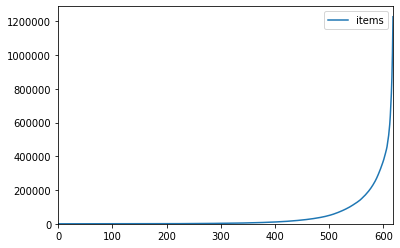

In [28]:
ax = items1.sort_values().cumsum().reset_index().plot()
ax.set_ylim(0);

### Top 10 presentations affected by change 1, by items

In [29]:
df1.sort_values(['items'], ascending=False).head(10)

,name,items,net_cost
bnf_code,,,
0906026M0AAAGAG,Thiamine HCl_Tab 100mg,216610,546200.82
0906027G0AAABAB,Vit B Co Strong_Tab,143969,471005.47
21220000235,Cetraben Crm 500g,94487,636215.76
21220000242,Epimax Crm 500g,72203,192340.70
0407010H0AAAAAA,Paracet_Cap 500mg,61869,207848.16
21300000702,Clinitas Carbomer Eye Gel,48480,102789.14
1202010M0AAACAC,Fluticasone Prop_Nsl Spy 50mcg (150 D),33827,273936.93
23803108006,3m Health Care_Cavilon Durable Barrier Crm 92g,31552,251428.39
21220000230,Zerodouble Gel,24672,137567.10


### Distribution of presentations affected by change 1, by net_cost

In [30]:
# Find the proprtion of presentations accounted for by the top 1%, 5%, 10%, 20% of prescribing, by net_cost
for percentile in [0.01, 0.05, 0.1, 0.2]:
    print(percentile, net_cost1[net_cost1 > net_cost1.quantile(1 - percentile)].sum() / net_cost1.sum())

0.01 0.29625967968164973
0.05 0.6613395896681702
0.1 0.8151351449011885
0.2 0.9391461893678298


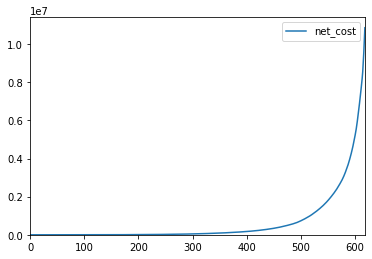

In [31]:
ax = net_cost1.sort_values().cumsum().reset_index().plot()
ax.set_ylim(0);

### Top 10 presentations affected by change 1, by net_cost

In [32]:
df1.sort_values(['net_cost'], ascending=False).head(10)

,name,items,net_cost
bnf_code,,,
090402000BBLMA0,Nutrison Pack_Energy M/Fibre,2082,666942.32
21220000235,Cetraben Crm 500g,94487,636215.76
0906026M0AAAGAG,Thiamine HCl_Tab 100mg,216610,546200.82
0906027G0AAABAB,Vit B Co Strong_Tab,143969,471005.47
090402000BBGYA0,Nutrison Pack_Energy,1236,343100.29
1202020L0AACCCC,Sod Chlor_Inh Soln 0.9% 2.5ml Ud Amp,8081,279162.33
1202010M0AAACAC,Fluticasone Prop_Nsl Spy 50mcg (150 D),33827,273936.93
090402000BBGXA0,Nutrison Pack_Conc Liq,690,271235.45
23803108006,3m Health Care_Cavilon Durable Barrier Crm 92g,31552,251428.39


---

## Change 2: special container quantity changes

### Affected presentations

In [33]:
quantity_change = pd.read_excel('../data/Special Container size mismatch between MDR and dm+d latest.xlsx')
print(f"There are {len(quantity_change)} changed records")
display(quantity_change.head())

There are 1822 changed records


,BNF Code,dm+d: BNF Description,MDR Quantity,dm+d: Quantity,dm+d: PACK Information
0,0106050B0BEAAA0,Moviprep oral powder sachets,1.0,4.0,4 sachets
1,0106050B0BEABA0,Moviprep Orange oral powder sachets,1.0,4.0,4 sachets
2,0107020J0AAAJAJ,Lidocaine 1% / Hydrocortisone 0.2% spray,1.0,30.0,30 mls
3,0107020J0BHAAAJ,Perinal spray,1.0,30.0,30 mls
4,0107020J0BJAAAJ,Germoloids HC spray,1.0,30.0,30 mls


### Total items and net_cost for each presentation affected by change 2 for November 2019

In [34]:
joined_bnf_codes = ", ".join("'{}'".format(bnf_code) for bnf_code in quantity_change['BNF Code'])

sql = """
SELECT
    p.bnf_code,
    p.name,
    SUM(rx.items) AS items,
    SUM(rx.net_cost_pence) / 100 AS net_cost
FROM public_draft.prescribing rx
INNER JOIN public_draft.presentation p
    ON rx.bnf_code = p.bnf_code
WHERE rx.month = '2019-11-01'
  AND p.bnf_code IN ({})
GROUP BY p.bnf_code, p.name
""".format(joined_bnf_codes)

df2 = bq.cached_read(sql, csv_path='../bq-cache/2019_11_items_and_spending2.csv')
df2.set_index('bnf_code', inplace=True)
df2.head()

,name,items,net_cost
bnf_code,,,
21300000108,Hyabak Sod Hyaluronate Eye Dps 10ml P/F,15528,162125.09
21300000401,Liquifilm 1.4% Polyvinyl Alcohol Eye Dps 15ml,11656,29085.10
21300000711,Xailin Night Paraf Eye Oint P/F 5g,43421,156743.40
23150901504,CliniMed_Appeel No Sting Medical Adh Remover A/Spy 50ml,6317,183511.12
1203010E0AAABAB,Benzydamine HCl_Spy 0.15% 30ml S/F,21406,67182.84


In [35]:
items2, net_cost2 = df2['items'], df2['net_cost']

### Percentage of items and net_cost that are affected by change 2

In [36]:
items2.sum() / total_items * 100

1.4898494160168612

In [37]:
net_cost2.sum() / total_net_cost * 100

3.2417807563555776

### Distribution of presentations affected by change 2, by items

In [38]:
# Find the proprtion of presentations accounted for by the top 1%, 5%, 10%, 20% of prescribing, by items
for percentile in [0.01, 0.05, 0.1, 0.2]:
    print(percentile, items2[items2 > items2.quantile(1 - percentile)].sum() / items2.sum())

0.01 0.4380237215973298
0.05 0.7494982963240924
0.1 0.8655276301147049
0.2 0.9481320551518887


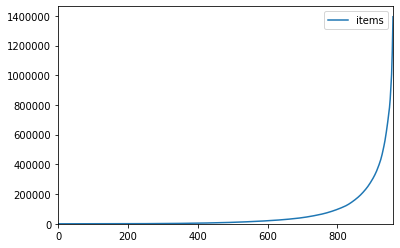

In [39]:
ax = items2.sort_values().cumsum().reset_index().plot()
ax.set_ylim(0);

### Top 10 presentations affected by change 2, by items

In [40]:
df2.sort_values(['items'], ascending=False).head(10)

,name,items,net_cost
bnf_code,,,
1108010F0AAAAAA,Hypromellose_Eye Dps 0.3%,118151,156821.91
120101050BCAAAB,Otomize_Ear Spy 5ml,112613,398207.52
21300000111,Hylo-Forte Sod Hyaluronate Eye Dps 0.2% P/F 10ml,82955,1033619.00
1106000ACAAAAAA,Brinzolamide_Eye Dps 10mg/ml,73444,254184.56
21220000311,Diprobase Crm 500g (App),43775,324351.84
21300000711,Xailin Night Paraf Eye Oint P/F 5g,43421,156743.40
23804708007,Smith & Nephew_Proshield Plus Skin Prote 115g,41716,536024.44
21300000104,Hylo-Tear Sod Hyaluronate Eye Dps 0.1% P/F 10ml,38514,417520.00
0301020S0BBAAAA,Seebri_Breezhaler Inh Cap 55mcg + Dev,29304,921215.28


### Distribution of presentations affected by change 2, by net_cost

In [41]:
# Find the proprtion of presentations accounted for by the top 1%, 5%, 10%, 20% of prescribing, by net_cost
for percentile in [0.01, 0.05, 0.1, 0.2]:
    print(percentile, net_cost2[net_cost2 > net_cost2.quantile(1 - percentile)].sum() / net_cost2.sum())

0.01 0.3149874674118635
0.05 0.7015026780245146
0.1 0.8425765622116822
0.2 0.9406182197270274


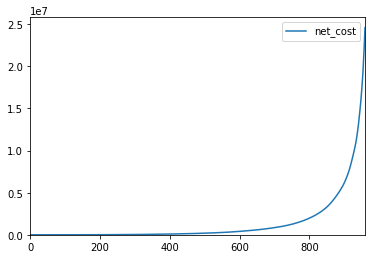

In [42]:
ax = net_cost2.sort_values().cumsum().reset_index().plot()
ax.set_ylim(0);

### Top 10 presentations affected by change 2, by net_cost

In [43]:
df2.sort_values(['net_cost'], ascending=False).head(10)

,name,items,net_cost
bnf_code,,,
21300000111,Hylo-Forte Sod Hyaluronate Eye Dps 0.2% P/F 10ml,82955,1033619.00
21020001196,Coloplast SpeediCath Compact Male OneSize 12/18(30-Pack)Cath,4624,1014858.96
0301020S0BBAAAA,Seebri_Breezhaler Inh Cap 55mcg + Dev,29304,921215.28
190700000BBCJA0,Resource_ThickenUp Clr Pdr,18710,854096.22
21020001190,Coloplast SpeediCath Compact Fle Size 8-14 (30-Pack) Cath,3473,787740.68
21020000880,Coloplast SpeediCath Male Size 10-14 (30-Pack) Cath,4260,780975.01
21020001408,LoFric Origo+Water Nelaton Male 40cm Size 10-18(30-Pack)Cath,3767,646156.02
21020001195,Coloplast SpeediCath Compact Plus Fle 10-14 (30-Pack) Cath,2755,610643.90
21020001254,LoFric Sense Nelaton Fle 15cm 8-14 (30-Pack) Cath Wellspect,2726,550377.45
